In [2]:
#Packages
%pylab
%matplotlib inline
import numpy as np
from scipy import stats
import scipy.ndimage
import matplotlib.pyplot as plt
from nuclei_segmentation import otsu as ot

Using matplotlib backend: <object object at 0x0000023BFB9FEC20>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# functions that still have to be defined: otsu_t(); otsu_i() and crop(image, first pixel coordinates, last pixel coordinates)

def crop1(image, xmin, ymin, xmax, ymax):
    cropped=np.empty([xmax-xmin, ymax-ymin], dtype=float)
    for a,b in np.ndindex(xmax-xmin, ymax-ymin):
        cropped[a,b]=image[a+xmin,b+ymin]
    return cropped
    
    
#def crop(image,x,y,w,z):
    h = w-x
    w = z-y
    cropped = np.zeros([h,w])
    for a in range(x,w):
        for b in range(y,z):
            cropped[a-x,b-y]=image[a,b]
    return cropped

def otsu_t(img,x):
    import matplotlib.pyplot
    import numpy
#bins optimieren.... alles zu 0-255 machen


   # load histogram, Mathematische werte aus Histogramm rausgreifen
    n, bins, patches = matplotlib.pyplot.hist(img.flatten(),log = 'False',bins = x)

   # initialize threshold value (T = 0) 
    thres = 0
    copy = img.copy()

    # create list to store values of within class variance for each threshold value
    bcv = list()
    
    # set up initial values
    for i in range(0,len(n)):
        bclv = 0
        w0_sum = 0
        mean_sum0 = 0
        v0_sum = 0
        mean_sum1 = 0
        v1_sum = 0
        w0 = 0
        w1 = 0
        w1_sum = 0

        #sum up the probabilites of each intensity value;  and the mean value (sind noch nicht happy mit der definition :()
        for j in range(0,i+1):
            w0_sum += n[j]
            mean_sum0 += bins[j]*n[j]
            
        # background class probabilites and class mean levels
        w0 = w0_sum / sum(n)  
        if(sum(n[0:i+1]) != 0):  
             mean_0 = mean_sum0 / sum(n[0:i+1])
        else: mean_0 = 0
        
        # compute background class variance
        for m in range(0,i+1):
            v0_sum += ((bins[m]-mean_0)** 2) * n[m]
        
        v0 = v0_sum / sum(n[0:i+1])
        
        # sum up the probabilites of each intensity value;  and the mean value
        for k in range(i+1, len(n)): 
            w1_sum += n[k]
          
            mean_sum1 += bins[k]*n[k]

        # compute foreground class probabilities and class mean levels    
        w1 = w1_sum / sum(n)
     
        if(sum(n[i+1:len(n)]) != 0):
            mean_1 = mean_sum1 / sum(n[i+1:len(n)])
        else: mean_1 = 0
        # compute foreground class variance 
        for s in range(i+1,len(n)):
            v1_sum += ((bins[s]-mean_1) ** 2) * n[s]
        if( sum(n[i+1:len(n)]) != 0):
            v1 = v1_sum / sum(n[i+1:len(n)])
        else: v1 = 0

        # compute within class variance and append to list
        bclv = (w0 * v0) + (w1 * v1)
        bcv.append(bclv)

    # select optimal threshold value, minimum value of within class variance
    optimal_thres = min(bcv)
    return optimal_thres

def otsu_i(image):
    img=ot.otsu_thresholding(image, 256)
    it = np.zeros([img.shape[0],img.shape[1],2])
    for x, y in np.ndindex(img.shape[0],img.shape[1]):
            if img[x,y] == 0:
                it[x,y,0]+=1
            else:
                it[x,y,0]+=0
            it[x,y,1]+=0.5
    return it


In [4]:
#sliding window average treshold method
#does not work yet
def t_sw(image, stepsize, framesize):
    img = copy(image)
    array = np.zeros([img.shape[0],img.shape[1],2])
    x=0
    y=0
    while y+framesize<=img.shape[1]:
        while x+framesize<=img.shape[0]:
            window=crop1(img,x,y,x+framesize, y+framesize)
            otsu_t(window, 256)
            for a, b in np.ndindex(window.shape[0], window.shape[1]):
                a+=x
                b+=y
                threshold = otsu_t(window, 256)
                array[a,b,0]+=threshold
                array[a,b,1]+=1
            x+=stepsize
        x=0
        y+=stepsize
        for i, j in np.ndindex(img.shape[0], img.shape[1]):
            t=array[i,j,0]/array[i,j,1]
            if img[i,j]<=t:
                img[i,j]=0
            else:
                img[i,j]=255
            return img



In [5]:
#sliding window foreground background assignment
#also does not work yet
def i_sw(image,stepsize,framesize):
    img=copy(image)
    intensity=np.max(img)
    array=np.zeros([img.shape[0],img.shape[1],2])
    x=0
    y=0
    while x+framesize<=img.shape[0]:
        while y+framesize<=img.shape[1]:
            window=crop1(img,x,y,x+framesize, y+framesize)
            it = otsu_i(window)
            for a, b in np.ndindex(window.shape[0], window.shape[1]):
                c=a+x
                d=b+y
                array[c,d]+=it[a,b]
            y+=stepsize
        y=0
        x+=stepsize
    for i, j in np.ndindex(img.shape[0], img.shape[1]):
        if array[i,j,0]>=array[i,j,1]:
            img[i,j]=0
        else:
            img[i,j]=255
    print(img)
    figure()
    imshow(img,'gray')
    return img
                


In [21]:
def t_sw(image,stepsize,framesize):
    img=copy(image)
    intensity=np.max(img)
    array=np.zeros([img.shape[0],img.shape[1],3])
    x=0
    y=0
    while x+framesize<=img.shape[0]:    
        while y+framesize<=img.shape[1]:
            window=crop1(img,x,y,x+framesize, y+framesize)
            threshold = otsu_t(window,255)
            for a, b in np.ndindex(window.shape[0], window.shape[1]):
                c=a+x
                d=b+y
                array[c,d,0]+=threshold
                array[c,d,1]+=1
            y+=stepsize
        y=0
        x+=stepsize
    for i, j in np.ndindex(img.shape[0], img.shape[1]):
        array[i,j,2]=array[i,j,0]/array[i,j,1]
        if img[i,j]>array[i,j,2]:
            img[i,j]=intensity
        else:
            img[i,j]=0
    print(img)
    figure()
    imshow(img,'gray')
    return img

C:\Users\ievas\AppData\Local\Temp\ipykernel_24680\3915694411.py:20: RuntimeWarning: invalid value encountered in double_scalars
  array[i,j,2]=array[i,j,0]/array[i,j,1]


[[  0 220 220 ...   0   0   0]
 [  0   0 220 ...   0   0   0]
 [  0   0 220 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[  0 220 220 ...   0   0   0]
 [  0   0 220 ...   0   0   0]
 [  0   0 220 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

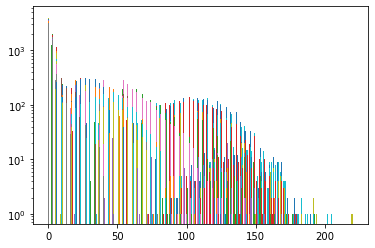

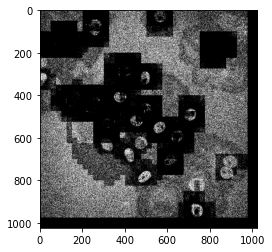

<Figure size 432x288 with 0 Axes>

In [30]:
img_1 = imread(r"data\Otsu_data\NIH3T3\img\dna-0.png") 
img_2 = imread(r"data\Otsu_data\N2DH-GOWT1\img\t39.tif")
img_3 = imread(r"data\Otsu_data\N2DL-HeLa\img\t13.tif") 
figure()
#sw1 = t_sw(img_1, 150, 350)
figure()
sw2 = t_sw(img_2, 50, 75)
print(sw2)
figure()
#sw3 = t_sw(img_3, 150, 350)

In [ ]:
img_1 = imread(r"data\Otsu_data\NIH3T3\img\dna-0.png") 
img_2 = imread(r"data\Otsu_data\N2DH-GOWT1\img\t39.tif")
img_3 = imread(r"data\Otsu_data\N2DL-HeLa\img\t13.tif") 
figure()
sw1 = t_sw(img_1, 60, 240)
figure()
sw2 = t_sw(img_2, 80, 280)
figure()
sw3 = t_sw(img_3, 60, 240)

[[[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


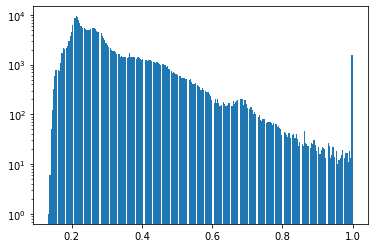

In [ ]:
img = copy(imgdna44)
array=np.zeros([img.shape[0],img.shape[1],1])
window=crop(img,0,0,500, 500)
it = otsu_i(window)
for a, b in np.ndindex(window.shape[0], window.shape[1]):
    c=a
    d=b
    array[c,d,0]+=it[a,b,0]
print(array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


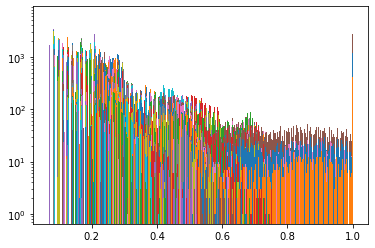

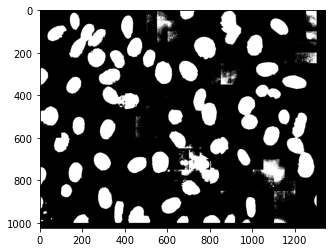

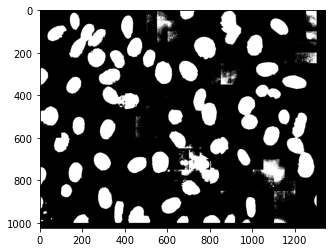

In [ ]:
img_3 = imread(r"data\Otsu_data\N2DL-HeLa\img\t13.tif")
gt10 = plt.imread(r'data\Otsu_data\NIH3T3\gt\33.png')
newimg44 = i_sw(imgdna44, 50, 100)
figure()
imshow(newimg44,'gray')

[[255. 255. 255. ...   0.   0.   0.]
 [255. 255. 255. ...   0.   0.   0.]
 [255. 255. 255. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


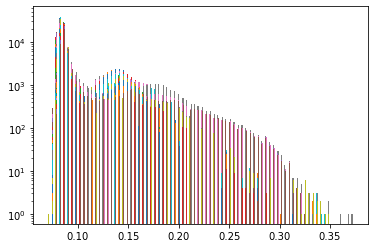

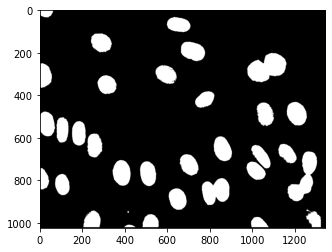

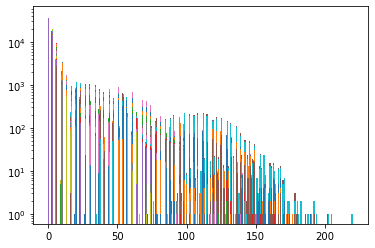

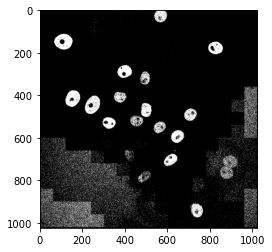

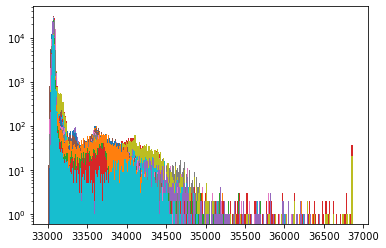

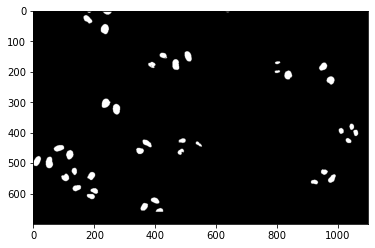

In [14]:
img_1 = imread(r"data\Otsu_data\NIH3T3\img\dna-0.png") 
img_2 = imread(r"data\Otsu_data\N2DH-GOWT1\img\t39.tif")
img_3 = imread(r"data\Otsu_data\N2DL-HeLa\img\t13.tif") 
figure()
sw1 = i_sw(img_1, 60, 240)
figure()
sw2 = i_sw(img_2, 60, 240)
figure()
sw3 = i_sw(img_3, 60, 240)

In [37]:
print(np.ndarray.max(sw2),np.ndarray.min(sw2), np.unique(sw2)) 



220 0 [  0 220]
